    Ben Christensen
    Math 323
    1/25/18

In [1]:
import numpy as np
from scipy import linalg as la
from scipy.stats import norm
from scipy.integrate import quad
from matplotlib import pyplot as plt

In [2]:

class GaussianQuadrature:
    """Class for integrating functions on arbitrary intervals using Gaussian
    quadrature with the Legendre polynomials or the Chebyshev polynomials.
    """
    # Problems 1 and 3
    def __init__(self, n, polytype="legendre"):
        """Calculate and store the n points and weights corresponding to the
        specified class of orthogonal polynomial (Problem 3). Also store the
        inverse weight function w(x)^{-1} = 1 / w(x).

        Parameters:
            n (int): Number of points and weights to use in the quadrature.
            polytype (string): The class of orthogonal polynomials to use in
                the quadrature. Must be either 'legendre' or 'chebyshev'.

        Raises:
            ValueError: if polytype is not 'legendre' or 'chebyshev'.
        """
        if polytype == "legendre":
            self.winv = lambda x: 1
        elif polytype == "chebyshev":
            self.winv = lambda x: np.sqrt(1-x**2)
        else:
            raise ValueError("Polynomial must be legendre or chebyshev class")

        self.polytype = polytype
        self.points, self.weights = self.points_weights(n)
    # Problem 2
    def points_weights(self, n):
        """Calculate the n points and weights for Gaussian quadrature.

        Parameters:
            n (int): The number of desired points and weights.

        Returns:
            points ((n,) ndarray): The sampling points for the quadrature.
            weights ((n,) ndarray): The weights corresponding to the points.
        """
        #Initialize the Beta Values. Both polytypes have alphas equal to zero
        if self.polytype == "legendre":
            B = [np.sqrt(k**2 / (4*k**2 - 1)) for k in range(1, n+1)]
            mew = 2
        elif self.polytype == "chebyshev":
            B = 1/4 * np.ones(n)
            B[0] = 2*B[0]
            B = np.sqrt(B)
            mew = np.pi
        #Initialize the Jacobi matrix J
        J = np.zeros((n,n))
        J[0][1] = B[0]
        j = 0
        for i in range(1, n-1):
            J[i][j] = B[j]
            J[i][j+2] = B[j+1]
            j += 1
        J[n-1][n-2] = B[-2]
        points, eigvectors = la.eig(J)
        #Calculate the weights from the eigenvectors
        weights = mew*np.array([vector[0]**2 for vector in eigvectors.T])

        return points, weights


    # Problem 3
    def basic(self, f):
        """Approximate the integral of a f on the interval [-1,1]."""
        g = lambda x: f(x) * self.winv(x)
        return self.weights @ g(self.points)

    # Problem 4
    def integrate(self, f, a, b):
        """Approximate the integral of a function on the interval [a,b].

        Parameters:
            f (function): Callable function to integrate.
            a (float): Lower bound of integration.
            b (float): Upper bound of integration.

        Returns:
            (float): Approximate value of the integral.
        """
        h = lambda x: f((b-a)/2 * x + (a+b)/2)
        return (b-a)/2 * self.basic(h)

    # Problem 6.
    def integrate2d(self, f, a1, b1, a2, b2):
        """Approximate the integral of the two-dimensional function f on
        the interval [a1,b1]x[a2,b2].

        Parameters:
            f (function): A function to integrate that takes two parameters.
            a1 (float): Lower bound of integration in the x-dimension.
            b1 (float): Upper bound of integration in the x-dimension.
            a2 (float): Lower bound of integration in the y-dimension.
            b2 (float): Upper bound of integration in the y-dimension.

        Returns:
            (float): Approximate value of the integral.
        """
        #define h(x,y) and g(x,y)
        h = lambda x,y: f((b1-a1)/2*x + (a1+b1)/2, (b2-a2)/2*y + (a2+b2)/2)
        g = lambda x,y: h(x,y)*self.winv(x)*self.winv(y)
        summation = 0
        #Calculate the approxmation of the double integral of f(x)
        for i, iweight in enumerate(self.weights):
            summation += np.sum([iweight*jweight*g(self.points[i], self.points[j]) for j, jweight in enumerate(self.weights)])
        return ((b1-a1)*(b2-a2))/4 * summation


# Problem 5
def prob5():
    """Use scipy.stats to calculate the "exact" value F of the integral of
    f(x) = (1/sqrt(2 pi))e^((-x^2)/2) from -3 to 2. Then repeat the following
    experiment for n = 5, 10, 15, ..., 50.
        1. Use the GaussianQuadrature class with the Legendre polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
        2. Use the GaussianQuadrature class with the Chebyshev polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
    Plot the errors against the number of points and weights n, using a log
    scale for the y-axis. Finally, plot a horizontal line showing the error of
    scipy.integrate.quad() (which doesn’t depend on n).
    """
    #Use scipy stats to find "exact" value of the integral
    a, b = -3, 2
    F = norm.cdf(b) - norm.cdf(a)
    f = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)
    legErrors = []
    chebErrors = []
    scipyErrors = []
    N = range(5, 55, 5)
    #find the error for each methods integral approximation for different sample sizes
    for n in N:
        #Legendre method
        Legend = GaussianQuadrature(n)
        legErrors.append(abs(F - Legend.integrate(f, a, b)))
        #Chebyshev method
        Cheb = GaussianQuadrature(n, "chebyshev")
        chebErrors.append(abs(F - Cheb.integrate(f, a, b)))
        scipyErrors.append(abs(F - quad(f, a, b)[0]))
    #Plot the errors
    plt.semilogy(N, legErrors, label="Legendre")
    plt.semilogy(N, chebErrors, label="Chebyshev")
    plt.semilogy(N, scipyErrors, label="Scipy")
    plt.title("Error")
    plt.xlabel("n")
    plt.legend(loc="center right")
    plt.show()


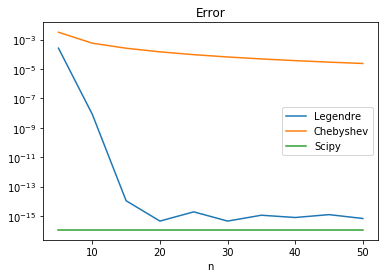

In [3]:
prob5()